# the purpose this work
- what's the goal of this analysis ?
    - proposer une methodologie simple, efficace et non couteuse en terme de calcule (c-à-d inference rapide) pour detecter la présence du covid-19 dans un enregistrement vocal de la toux.
    - explorer different techniques dapprentissage automatique pour le diagnostique medical.
- Do I need machine learning or deep learning ?
    - montrer lefficacité de quelques méthodes en comparant avec d'autres (également avec des architectures neuronal).
- Future work:
    - comme travail future, on va essayer de faire une extension de cette méthodologie pour l'utiliser avec d'autres maladies possibles qui peuvent être traitées avec le signal audio.


# Table of Contents <a class='anchor' id='toc'></a>

#### I. [Import Data & Libraries & Modules](#idl)
#### II. [Data Pre-processing](#dpp)
#### III. [Train/Test Split](#tts)
#### IV. [Machine Learning Models](#mlm)
#### V. [Deep Learning Models](#dlm)
#### VI. [Pick the Best Model](#pbm)
#### VII. [Best Model Evaluation](#bme)

# I. Import Data & Libraries & modules <a class="anchor" id="idl"></a>

Importing necessary libraries and modules

In [305]:
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets
import pandas as pd  # For data manipulation and analysis
import os  # For interacting with the operating system
import librosa  # For audio feature extraction
import librosa.display  # For displaying audio waveforms and spectrograms
import cv2  # For image processing
import numpy as np  # For numerical computations
import json  # For working with JSON files
import matplotlib.pyplot as plt  # For creating visualizations
import warnings  # For managing warning messages

# Additional dependencies and modules
from unsilence import Unsilence  # For removing silence from audio
from pydub import AudioSegment  # For audio file manipulation
import soundfile as sf  # For reading and writing audio files
import opensmile  # For audio feature extraction using OpenSMILE toolkit
import pickle  # For serializing and deserializing Python objects

# Modules for model training and evaluation
from sklearn.model_selection import RandomizedSearchCV  # For hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from sklearn.model_selection import cross_val_score  # For cross-validation
from sklearn.model_selection import cross_validate  # For cross-validation with multiple metrics
from sklearn.model_selection import validation_curve  # For plotting validation curves
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score,
    recall_score, classification_report, confusion_matrix, balanced_accuracy_score
)  # Various evaluation metrics for classification
from sklearn.metrics import make_scorer  # For creating custom scoring functions

# Modules for handling imbalanced datasets
from imblearn.metrics import specificity_score  # For calculating specificity
from imblearn.under_sampling import RandomUnderSampler  # Random under-sampling
from imblearn.over_sampling import RandomOverSampler  # Random over-sampling
from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique

# Modules for cross-validation and hyperparameter tuning
from sklearn.model_selection import StratifiedKFold  # For stratified k-fold cross-validation
from sklearn.svm import LinearSVC  # Linear Support Vector Classifier
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.model_selection import GridSearchCV  # For grid search and hyperparameter tuning

# Additional libraries for audio feature extraction
import math  # For mathematical computations
import seaborn as sns  # For creating visualizations
from speechpy.feature import mfcc  # For Mel-frequency cepstral coefficients (MFCC) extraction


In [306]:
# Ignore all warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')
# Path variables for metadata, audio data, and MFCC files
metaDataPath = "/Users/iyadchehili/Desktop/thesis/data/public_dataset/public_dataset/metadata_compiled.csv"
audiodataPath = "/Users/iyadchehili/Desktop/thesis/data/webm-files/"
mfccsPath = "/Users/iyadchehili/Desktop/thesis/data/mfccs/mfccs-final.csv"

## II. Data Pre-processing<a class="anchor" id="dpp"></a>
**[Back to top](#toc)**

Read the data

In [307]:
# Read the dataset from a Parquet file
#df = pd.read_csv(mfccsPath).sample(frac=0.0005)
df = pd.read_parquet(mfccsPath)
df

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c225,c226,c227,c228,c229,c230,c231,c232,c233,covid_status
0,-563.337891,18.238453,-2.340280,5.720764,-5.836890,7.594863,-4.868218,-0.771808,-0.109394,-3.058184,...,10.603173,9.948966,15.936632,12.325701,15.612232,11.181804,13.001097,10.949319,27.825075,0
1,-278.879547,100.888168,-25.865992,15.782073,-21.624033,3.497478,-3.594802,-6.801463,5.152771,-3.411121,...,2.537391,0.234807,1.338121,0.596081,-0.246269,0.222006,0.143543,1.949368,1.677189,0
2,-519.862183,26.079721,-28.713432,7.987692,-11.941558,7.747051,-14.822470,-4.978141,-13.012679,0.522780,...,8.049055,6.684384,9.295294,7.796215,7.626485,13.558840,3.499619,4.158421,4.454043,0
3,-517.533997,125.805275,-59.390606,-13.782511,4.535457,-24.435947,5.241576,-2.421912,-26.353161,-3.304838,...,1.490015,1.154809,0.277357,0.515836,0.236132,-0.234576,3.412396,0.813236,0.109381,1
4,-514.592529,14.008998,-14.682418,2.345538,-7.689001,3.383961,-2.569572,-1.549982,-1.093467,1.475932,...,13.564226,7.877328,15.789228,14.153807,12.275732,9.389269,9.945896,10.580207,10.930882,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,-420.832428,24.159922,-7.462646,-1.109118,-7.297370,2.585538,-3.614888,-2.995870,-2.900810,-2.309816,...,7.438333,13.595423,8.218443,11.587276,11.786143,13.948130,10.904981,11.123448,7.479071,0
11310,-509.111389,29.669987,-13.902734,3.884700,-7.175025,2.622873,-6.486012,2.428139,2.001534,1.966568,...,4.287909,7.201852,9.352594,5.025376,3.757401,6.213600,4.211870,5.465702,7.087398,0
11311,-542.518860,25.574539,-14.508806,1.267237,-20.686975,10.908496,-22.325382,4.440298,-8.084347,-1.617724,...,2.376305,2.893912,4.851071,4.974593,2.251657,1.338482,1.424889,1.009149,2.099168,0
11312,-448.928528,31.205353,-55.021175,20.766863,-13.703185,-11.568757,-8.959800,-12.043240,4.862084,1.540974,...,1.652596,1.413231,6.992211,2.462015,0.622708,4.137157,3.161835,2.429194,5.825694,1


In [308]:
# Display information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Columns: 235 entries, c0 to covid_status
dtypes: float32(234), int64(1)
memory usage: 10.2 MB


In [309]:
# Count the number of NaN values in each column
nan_columns = df.isnull().sum()
# Count the number of rows with at least one NaN value
nan_rows = df.isnull().any(axis=1).sum()
# Print the results
print("Number of columns with NaN values:", nan_columns.sum())
print("Number of rows with at least one NaN value:", nan_rows)

Number of columns with NaN values: 3668
Number of rows with at least one NaN value: 48


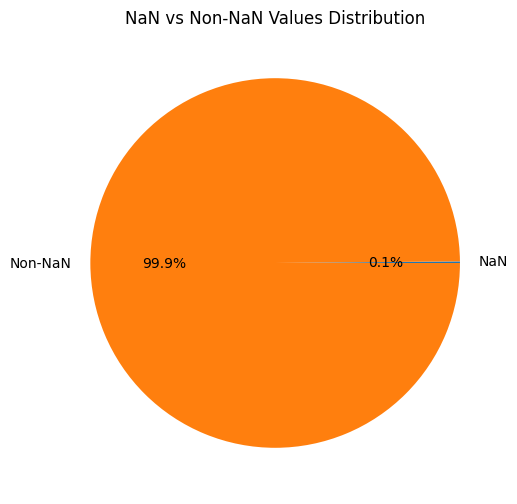

In [310]:
import matplotlib.pyplot as plt

# Count the number of non-NaN values in each column
non_nan_columns = df.notnull().sum()

# Calculate the total number of values in each column
total_values = len(df)

# Calculate the number of NaN values in each column
nan_columns = total_values - non_nan_columns

# Calculate the percentage of NaN and non-NaN values in each column
nan_percentage = (nan_columns / total_values) * 100
non_nan_percentage = (non_nan_columns / total_values) * 100

# Plotting the pie chart
plt.figure(figsize=(8, 6))
labels = ['NaN', 'Non-NaN']
plt.pie([nan_percentage.sum(), non_nan_percentage.sum()], labels=labels, autopct='%1.1f%%')
plt.title('NaN vs Non-NaN Values Distribution')
plt.show()


### The Distribution of NAN is too small compared to the rest of the numbers so we take a decision to Drop them

In [311]:
# Drop rows with NaN values
df_dropped_rows = df.dropna(axis=0)
# Count the number of NaN values in each column
nan_columns = df_dropped_rows.isnull().sum()
# Count the number of rows with at least one NaN value
nan_rows = df_dropped_rows.isnull().any(axis=1).sum()
# Print the results after dropping rows
print("Number of columns with NaN values:", nan_columns.sum())
print("Number of rows with at least one NaN value:", nan_rows)

Number of columns with NaN values: 0
Number of rows with at least one NaN value: 0


In [312]:
# Print the shape (number of rows and columns) of the df_dropped_rows dataframe
print(df_dropped_rows.shape)

(11266, 235)


### the distribution of Covid-19 and Non-Covid-19 

In [313]:
# Count the occurrences of each unique value in the 'covid_status' column of the df_dropped_rows dataframe
df_dropped_rows.covid_status.value_counts()

0    8525
1    2741
Name: covid_status, dtype: int64

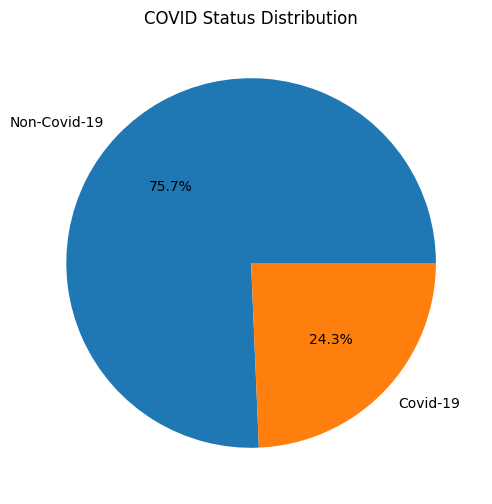

In [314]:
# Calculate the value counts of 'covid_status' column
value_counts = df_dropped_rows['covid_status'].value_counts()

# Define the class labels for the pie chart
class_labels = ['Non-Covid-19', 'Covid-19']
# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=class_labels, autopct='%1.1f%%')
plt.title('COVID Status Distribution')
plt.show()


As we can see we have a smaller number of COVID-19 samples compared to healthy samples, which creates an imbalance in our dataset. This class imbalance can negatively impact the performance of our classification model. So to solve this problem we decide to use oversampling using the SMOTE method.

In [315]:
# Splitting the dataframe into features (X) and target (Y)
X = df_dropped_rows.drop('covid_status', axis=1)
Y = df_dropped_rows['covid_status']
#print(X_train.shape)
# Display the shape of the features and target arrays
print(X.shape)
print(Y.shape)

(11266, 234)
(11266,)


### Perform oversampling using SMOTE (Synthetic Minority Over-sampling Technique)


In [316]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_res, Y_res = sm.fit_resample(X, Y.ravel())

In [317]:
# Print the shape of the oversampled dataset
print(X_res.shape)
print(Y_res.shape)

(17050, 234)
(17050,)


In [318]:
# Print the counts of the two classes in the oversampled target array
print(len(Y_res[Y_res==0]),len(Y_res[Y_res==1]))

8525 8525


### Distribution of classes after using SMOTE

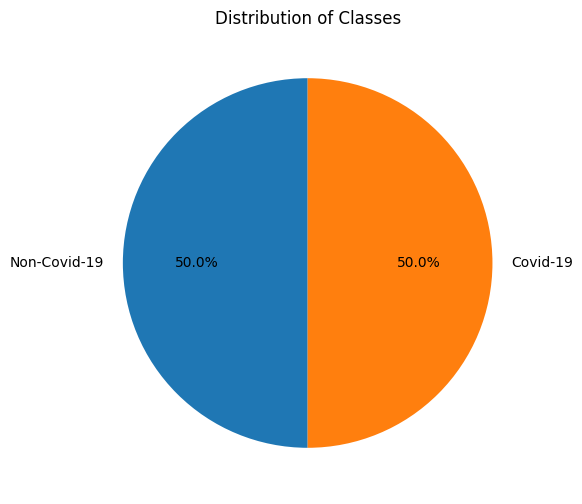

In [319]:
# Count the occurrences of each class in the oversampled target array
class_counts = [len(Y_res[Y_res == 0]), len(Y_res[Y_res == 1])]

# Define the class labels for the pie chart
class_labels = ['Non-Covid-19', 'Covid-19']

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90)

# Add a title to the pie chart
plt.title('Distribution of Classes')

# Display the pie chart
plt.show()

### the distribution of our dataset before using the Standardization

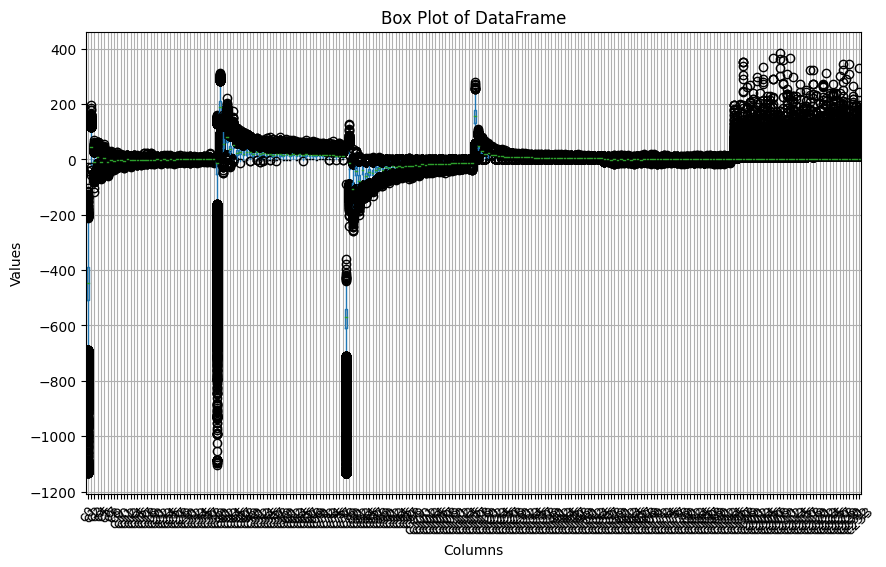

In [320]:
import matplotlib.pyplot as plt

# Create a box plot for each column in the dataframe
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

X_res.boxplot()

# Set the title and labels for the plot
plt.title("Box Plot of DataFrame")
plt.xlabel("Columns")
plt.ylabel("Values")

# Rotate the x-axis labels if necessary
plt.xticks(rotation=45)

# Display the plot
plt.show()


### Now we scale and normalize the features of our dataset

Standardization brings the features to a similar scale, centered around 0 with a standard deviation of 1. This is ensures that no single feature dominates the learning algorithm due to its larger magnitude.

In [321]:
# Standardize the feature matrix using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_res)
X_res=scaler.transform(X_res)
# The resulting oversampled and standardized feature matrix
X_res

array([[-0.7730267 , -1.1638055 ,  0.6605224 , ...,  0.9593701 ,
         0.74531496,  2.372832  ],
       [ 1.4579351 ,  1.9622406 , -0.84188914, ..., -0.47664964,
        -0.28993225, -0.2981797 ],
       [-0.43205357, -0.8672265 , -1.023734  , ..., -0.10182007,
        -0.03582909, -0.0145235 ],
       ...,
       [ 0.27007416,  1.4625543 ,  1.0567813 , ..., -0.508943  ,
        -0.45850372, -0.46475816],
       [-0.201611  ,  0.52525645,  0.7075674 , ..., -0.31184584,
        -0.29013804, -0.37298855],
       [-0.10249866, -0.52074164,  1.0114633 , ...,  0.38205537,
        -0.20796677, -0.18473837]], dtype=float32)

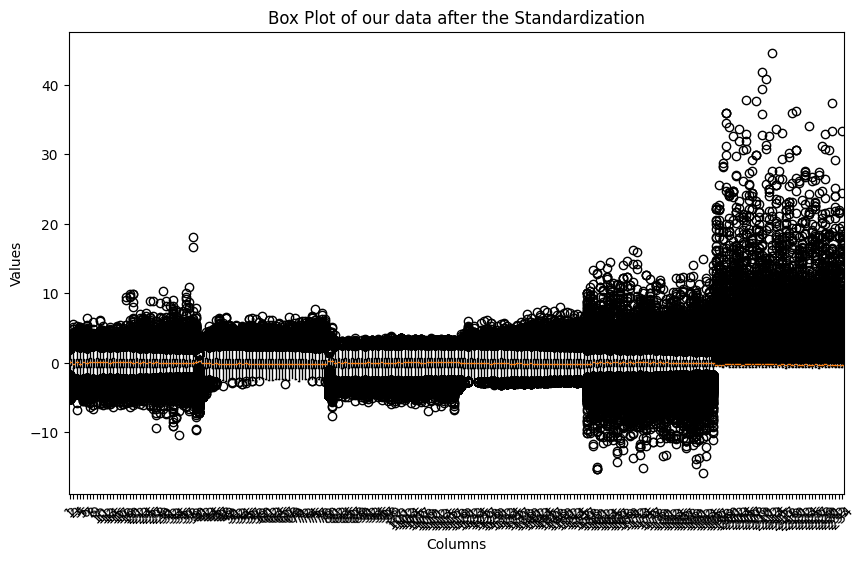

In [322]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

plt.boxplot(X_res)

# Set the title and labels for the plot
plt.title("Box Plot of our data after the Standardization")
plt.xlabel("Columns")
plt.ylabel("Values")

# Rotate the x-axis labels if necessary
plt.xticks(rotation=45)

# Display the plot
plt.show()

# IIII. Train/Test Split<a class="anchor" id="tts"></a>
**[Back to top](#toc)**

split the data into 80% for training and 20% for testing.

In [323]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, test_size=0.2, random_state=42)
type(Y_train)

numpy.ndarray

In [324]:
# distribution of covid-19 status in the training subset
print(len(Y_train[Y_train==0]),len(Y_train[Y_train==1]))

6831 6809


# IV. Machine Learning Models <a class="anchor" id="mlm"></a>
**[Back to top](#toc)**

**In this section we will use different machine learning models with different Hyperparameter setups which allow us to compare and evaluate the performance of different models under different settings, by using different machine learning models, we can assess how well each model fits the data and determine which model is most suitable for our problem. Additionally, adjusting the hyperparameters of each model helps fine-tune their behavior and optimize their performance.**

## SVM models

### SVM classifier with a linear kernel

In [79]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, Y_train)
Y_pred_linear = svm_linear.predict(X_test)
print(Y_test)
print(Y_pred_linear)
print("Accuracy:", accuracy_score(Y_test, Y_pred_linear))
print("Precision:",precision_score(Y_test, Y_pred_linear))
print("Recall:",recall_score(Y_test, Y_pred_linear))
print("f1-score:", f1_score(Y_test, Y_pred_linear))
print("ROC_AUC:", roc_auc_score(Y_test, Y_pred_linear))
print("Specificity:", specificity_score(Y_test, Y_pred_linear))

[0 1 1 ... 0 0 1]
[1 1 0 ... 1 0 0]
accuracy: 0.5750733137829912
f1-score: 0.5896346644010196
Precision: 0.5735537190082645
Recall: 0.6066433566433567
balanced accuracy: 0.5748683135046772


### SVM classifier with a Radial Basis Function kernel (Gaussian)

In [93]:
svm_rbf = SVC(kernel='rbf',C=1)
svm_rbf.fit(X_train, Y_train)
# predict on test data
Y_pred_rbf = svm_rbf.predict(X_test)
print(Y_test)
print(Y_pred_rbf)
print("Accuracy:", accuracy_score(Y_test, Y_pred_rbf))
print("Precision:",precision_score(Y_test, Y_pred_rbf))
print("Recall:",recall_score(Y_test, Y_pred_rbf))
print("f1-score:", f1_score(Y_test, Y_pred_rbf))
print("ROC_AUC:", roc_auc_score(Y_test, Y_pred_rbf))
print("Specificity:", specificity_score(Y_test, Y_pred_rbf))

[0 1 1 ... 0 0 1]
[1 1 1 ... 0 0 1]
Accuracy: 0.7653958944281525
Precision: 0.7608200455580866
Recall: 0.7785547785547785
f1-score: 0.7695852534562212
ROC_AUC: 0.765310447128629
Specificity: 0.7520661157024794


### SVM classifier with polynomial kernel + (degree,gama) hyperparameters-tuning

In [94]:
############################# create an instance of the svm_model   polynomial (degree=3++) with gama
# Create a Polynomial SVM model
svm_poly = SVC(kernel='poly', degree=3, gamma=0.1)
svm_poly.fit(X_train, Y_train)
# predict on test data
Y_pred_poly = svm_poly.predict(X_test)
print(Y_test)
print(Y_pred_poly)
print("Accuracy:", accuracy_score(Y_test, Y_pred_poly))
print("Precision:",precision_score(Y_test, Y_pred_poly))
print("Recall:",recall_score(Y_test, Y_pred_poly))
print("f1-score:", f1_score(Y_test, Y_pred_poly))
print("ROC_AUC:", roc_auc_score(Y_test, Y_pred_poly))
print("Specificity:", specificity_score(Y_test, Y_pred_poly))

[0 1 1 ... 0 0 1]
[1 1 1 ... 0 0 1]
Accuracy: 0.8079178885630498
Precision: 0.7452612112806287
Recall: 0.9393939393939394
f1-score: 0.831142046919309
ROC_AUC: 0.8070641479732389
Specificity: 0.6747343565525383


# Random Forest models

### Random forest classifier with criterion ='entropy' + bootstrap=True

In [76]:
rfe = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion ='entropy', random_state=42)
# Train the model on the training data
rfe.fit(X_train, Y_train)
# Make predictions on the test data
Y_pred_rfe = rfe.predict(X_test)
print(Y_test)
print(Y_pred_rfe)
print("Accuracy:", accuracy_score(Y_test, Y_pred_rfe))
print("Precision:",precision_score(Y_test, Y_pred_rfe))
print("Recall:",recall_score(Y_test, Y_pred_rfe))
print("f1-score:", f1_score(Y_test, Y_pred_rfe))
print("ROC_AUC:", roc_auc_score(Y_test, Y_pred_rfe))
print("Specificity:", specificity_score(Y_test, Y_pred_rfe))

[0 1 1 ... 0 0 1]
[1 1 1 ... 0 1 1]
accuracy: 0.8648093841642229
f1-score: 0.8623469692445506
Precision: 0.8842620943049602
Recall: 0.8414918414918415
balanced accuracy: 0.8649607967789786


### Random forest classifier with criterion ='gini' + bootstrap=False

In [95]:
rf_gini = RandomForestClassifier(n_estimators=500, bootstrap=False, criterion ='gini', random_state=42, verbose=10)
# Train the model on the training data
rf_gini.fit(X_train, Y_train)
# Make predictions on the test data
Y_pred_rf_gini = rf_gini.predict(X_test)
print(Y_test)
print(Y_pred_rf_gini)
print("Accuracy:", accuracy_score(Y_test, Y_pred_rf_gini))
print("Precision:",precision_score(Y_test, Y_pred_rf_gini))
print("Recall:",recall_score(Y_test, Y_pred_rf_gini))
print("f1-score:", f1_score(Y_test, Y_pred_rf_gini))
print("ROC_AUC:", roc_auc_score(Y_test, Y_pred_rf_gini))
print("Specificity:", specificity_score(Y_test, Y_pred_rf_gini))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 500


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 500


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s


building tree 4 of 500


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s


building tree 5 of 500


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s remaining:    0.0s


building tree 6 of 500


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.2s remaining:    0.0s


building tree 7 of 500


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.5s remaining:    0.0s


building tree 8 of 500


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.9s remaining:    0.0s


building tree 9 of 500


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.3s remaining:    0.0s


building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51

building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s


[0 1 1 ... 0 0 1]
[1 1 1 ... 0 1 1]
Accuracy: 0.8835777126099706
Precision: 0.9252095422308189
Recall: 0.8362470862470862
f1-score: 0.8784817875726967
ROC_AUC: 0.8838850543395997
Specificity: 0.9315230224321134


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


# KNN models

### KNN model with Hyper-parameters tuning using GridSearch

In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
# Create a KNN classifier
knn = KNeighborsClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the best model
accuracy = accuracy_score(Y_test, y_pred)
print("Best Parameters:", best_params)
print("Best Model Accuracy:", accuracy)


Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best Model Accuracy: 0.567741935483871


Apply the GridSearch's result

In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=3,weights='distance',p=1)

# Train the KNN classifier
knn.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred_knn = knn.predict(X_test)
print(Y_test)
print(Y_pred_knn)
print("Accuracy:", accuracy_score(Y_test, Y_pred_knn))
print("Precision:",precision_score(Y_test, Y_pred_knn))
print("Recall:",recall_score(Y_test, Y_pred_knn))
print("f1-score:", f1_score(Y_test, Y_pred_knn))
print("ROC_AUC:", roc_auc_score(Y_test, Y_pred_knn))
print("Specificity:", specificity_score(Y_test, Y_pred_knn))

[0 1 1 ... 0 0 1]
[1 1 1 ... 1 1 1]
Accuracy: 0.567741935483871
Precision: 0.5385105028644176
Recall: 0.986013986013986
f1-score: 0.6965829559489503
ROC_AUC: 0.5650258832077014
Specificity: 0.14403778040141677


# Decision Tree Classifier

In [97]:
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
decision_tree = DecisionTreeClassifier(
    criterion='gini',  # or 'entropy'
    max_depth=None,  # or an integer value
    min_samples_split=2,  # or an integer value
    min_samples_leaf=1,  # or an integer value
    max_features=None,  # or a fraction or an integer value
    min_impurity_decrease=0.0  # or a float value
)

# Train the decision tree classifier
decision_tree.fit(X_train, Y_train)

# Make predictions on the test set
y_pred_dt = decision_tree.predict(X_test)
print(Y_test)
print(y_pred_dt)
print("Accuracy:", accuracy_score(Y_test, y_pred_dt))
print("Precision:",precision_score(Y_test, y_pred_dt))
print("Recall:",recall_score(Y_test, y_pred_dt))
print("f1-score:", f1_score(Y_test, y_pred_dt))
print("ROC_AUC:", roc_auc_score(Y_test, y_pred_dt))
print("Specificity:", specificity_score(Y_test, y_pred_dt))


[0 1 1 ... 0 0 1]
[0 0 0 ... 1 0 0]
Accuracy: 0.658357771260997
Precision: 0.6452293094359515
Recall: 0.7132867132867133
f1-score: 0.6775532798228618
ROC_AUC: 0.6580010898192716
Specificity: 0.60271546635183


# Extra Trees Classifier

Extra Trees uses the entire feature set Unlike Random Forests, where a subset of features is randomly chosen for each split. This leads to a higher level of randomness and diversity among the trees. Extra Trees randomly selects a split point for each feature, rather than searching for the best split. 

In [325]:
from sklearn.ensemble import ExtraTreesClassifier

# Create an Extra Trees Classifier model
ExtraTrees = ExtraTreesClassifier(
    n_estimators=30,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    bootstrap=True,
    random_state=60
)

# Train the model
ExtraTrees.fit(X_train, Y_train)
# Make predictions on the test set
Y_pred_ExtraTrees = ExtraTrees.predict(X_test)
print(Y_test)
print(Y_pred_ExtraTrees)
print("Accuracy:", accuracy_score(Y_test, Y_pred_ExtraTrees))
print("Precision:",precision_score(Y_test, Y_pred_ExtraTrees))
print("Recall:",recall_score(Y_test, Y_pred_ExtraTrees))
print("f1-score:", f1_score(Y_test, Y_pred_ExtraTrees))
print("ROC_AUC:", roc_auc_score(Y_test, Y_pred_ExtraTrees))
print("Specificity:", specificity_score(Y_test, Y_pred_ExtraTrees))

[0 1 1 ... 0 0 1]
[1 1 1 ... 0 0 1]
Accuracy: 0.8196480938416423
Precision: 0.8236331569664903
Recall: 0.8164335664335665
f1-score: 0.820017559262511
ROC_AUC: 0.8196689673962402
Specificity: 0.8229043683589138


## Extra trees classifier with different hyperparameters 

In [176]:
from sklearn.ensemble import ExtraTreesClassifier

# Create an Extra Trees Classifier model
ExtraTrees = ExtraTreesClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    bootstrap=False,
    random_state=60
)

# Train the model
ExtraTrees.fit(X_train, Y_train)
# Make predictions on the test set
Y_pred_ExtraTrees = ExtraTrees.predict(X_test)
print(Y_test)
print(Y_pred_ExtraTrees)
print("Accuracy:", accuracy_score(Y_test, Y_pred_ExtraTrees))
print("Precision:",precision_score(Y_test, Y_pred_ExtraTrees))
print("Recall:",recall_score(Y_test, Y_pred_ExtraTrees))
print("f1-score:", f1_score(Y_test, Y_pred_ExtraTrees))
print("ROC_AUC:", roc_auc_score(Y_test, Y_pred_ExtraTrees))
print("Specificity:", specificity_score(Y_test, Y_pred_ExtraTrees))

[0 1 1 ... 0 0 1]
[1 1 1 ... 0 0 1]
Accuracy: 0.9005865102639297
Precision: 0.9371428571428572
Recall: 0.8601398601398601
f1-score: 0.8969917958067456
ROC_AUC: 0.9008491508491507
Specificity: 0.9415584415584416


# -xgboost- XGB Classifier

**-xgboost- xgb**

In [99]:
import xgboost as xgb

# Create an XGBoost Classifier model
xgb = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=900,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0
)

# Train the model
xgb.fit(X_train, Y_train)

# Make predictions on the test set
y_pred_xgb = xgb.predict(X_test)
print(Y_test)
print(y_pred_xgb)
print("Accuracy:", accuracy_score(Y_test, y_pred_xgb))
print("Precision:",precision_score(Y_test, y_pred_xgb))
print("Recall:",recall_score(Y_test, y_pred_xgb))
print("f1-score:", f1_score(Y_test, y_pred_xgb))
print("ROC_AUC:", roc_auc_score(Y_test, y_pred_xgb))
print("Specificity:", specificity_score(Y_test, y_pred_xgb))


[0 1 1 ... 0 0 1]
[1 1 1 ... 0 0 1]
Accuracy: 0.8428152492668621
Precision: 0.8394706559263522
Recall: 0.8502331002331003
f1-score: 0.8448176027793862
ROC_AUC: 0.842767081403445
Specificity: 0.8353010625737899


**XGBClassifier which is a specific class within the XGBoost library that focuses on classification tasks**

In [147]:
from xgboost import XGBClassifier
XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
XGB.fit(X_train, Y_train)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=500, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
Y_pred_XGB = XGB.predict(X_test)
print(Y_test)
print(Y_pred_XGB)
print("Accuracy:", accuracy_score(Y_test, Y_pred_XGB))
print("Precision:",precision_score(Y_test, Y_pred_XGB))
print("Recall:",recall_score(Y_test, Y_pred_XGB))
print("f1-score:", f1_score(Y_test, Y_pred_XGB))
print("ROC_AUC:", roc_auc_score(Y_test, Y_pred_XGB))
print("Specificity:", specificity_score(Y_test, Y_pred_XGB))

accuracy: 0.8087976539589443
f1-score: 0.814033086138049
Precision: 0.7972067039106145
Recall: 0.8315850815850816
balanced accuracy: 0.8086496836496837


# Logistic Regression

In [100]:
from sklearn.linear_model import LogisticRegression
# Create a logistic regression classifier
logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=100
)
# Train the logistic regression classifier
logreg.fit(X_train, Y_train)
# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test)
print(Y_test)
print(y_pred_logreg)
print("Accuracy:", accuracy_score(Y_test, y_pred_logreg))
print("Precision:",precision_score(Y_test, y_pred_logreg))
print("Recall:",recall_score(Y_test, y_pred_logreg))
print("f1-score:", f1_score(Y_test, y_pred_logreg))
print("ROC_AUC:", roc_auc_score(Y_test, y_pred_logreg))
print("Specificity:", specificity_score(Y_test, y_pred_logreg))

[0 1 1 ... 0 0 1]
[1 1 0 ... 1 0 1]
Accuracy: 0.5689149560117303
Precision: 0.5726950354609929
Recall: 0.5646853146853147
f1-score: 0.5686619718309859
ROC_AUC: 0.5689424212151485
Specificity: 0.5731995277449823


# naive bayes

**Gaussian Naive Bayes**

In [101]:
from sklearn.naive_bayes import GaussianNB
GaussianNB = GaussianNB()
# Train the model
GaussianNB.fit(X_train, Y_train)
# Make predictions on the test set
y_pred_GaussianNB = GaussianNB.predict(X_test)
print(Y_test)
print(y_pred_GaussianNB)
print("Accuracy:", accuracy_score(Y_test, y_pred_GaussianNB))
print("Precision:",precision_score(Y_test, y_pred_GaussianNB))
print("Recall:",recall_score(Y_test, y_pred_GaussianNB))
print("f1-score:", f1_score(Y_test, y_pred_GaussianNB))
print("ROC_AUC:", roc_auc_score(Y_test, y_pred_GaussianNB))
print("Specificity:", specificity_score(Y_test, y_pred_GaussianNB))

[0 1 1 ... 0 0 1]
[1 1 0 ... 1 1 1]
Accuracy: 0.5419354838709678
Precision: 0.52697967764541
Recall: 0.8764568764568764
f1-score: 0.6582056892778994
ROC_AUC: 0.5397632670359943
Specificity: 0.20306965761511217


**Bernoulli Naive Bayes**

In [102]:
from sklearn.naive_bayes import BernoulliNB

BernoulliNB = BernoulliNB(alpha=0.1)
# Train the model
BernoulliNB.fit(X_train, Y_train)
# Make predictions on the test set
y_pred_BernoulliNB = BernoulliNB.predict(X_test)
print(Y_test)
print(y_pred_BernoulliNB)
print("Accuracy:", accuracy_score(Y_test, y_pred_BernoulliNB))
print("Precision:",precision_score(Y_test, y_pred_BernoulliNB))
print("Recall:",recall_score(Y_test, y_pred_BernoulliNB))
print("f1-score:", f1_score(Y_test, y_pred_BernoulliNB))
print("ROC_AUC:", roc_auc_score(Y_test, y_pred_BernoulliNB))
print("Specificity:", specificity_score(Y_test, y_pred_BernoulliNB))

[0 1 1 ... 0 0 1]
[1 1 0 ... 1 1 1]
Accuracy: 0.5366568914956011
Precision: 0.5365984930032293
Recall: 0.581002331002331
f1-score: 0.5579182988248461
ROC_AUC: 0.5363689340962068
Specificity: 0.49173553719008267


# Linear Discriminant Analysis

In [110]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create an LDA object
lda = LinearDiscriminantAnalysis(
    solver='eigen',
    shrinkage=0.5,
    n_components=1
)

# Fit the LDA model on the training data
lda.fit(X_train, Y_train)

# Transform the training and testing data
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

# Use a classifier on the transformed data (e.g., Logistic Regression)
clf = LogisticRegression()
clf.fit(X_train_lda, Y_train)

# Make predictions on the test set
y_pred_lda = clf.predict(X_test_lda)

print(Y_test)
print(y_pred_lda)
print("Accuracy:", accuracy_score(Y_test, y_pred_lda))
print("Precision:",precision_score(Y_test, y_pred_lda))
print("Recall:",recall_score(Y_test, y_pred_lda))
print("f1-score:", f1_score(Y_test, y_pred_lda))
print("ROC_AUC:", roc_auc_score(Y_test, y_pred_lda))
print("Specificity:", specificity_score(Y_test, y_pred_lda))

[0 1 1 ... 0 0 1]
[1 1 0 ... 1 0 0]
Accuracy: 0.5627565982404692
Precision: 0.5652930934416716
Recall: 0.5675990675990676
f1-score: 0.566443733643501
ROC_AUC: 0.5627251536342446
Specificity: 0.5578512396694215


# Gradient Boosting Classifier

In [111]:
from sklearn.ensemble import GradientBoostingClassifier


# Create a Gradient Boosting Classifier
GboostingC = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

# Train the model
GboostingC.fit(X_train, Y_train)

# Make predictions on the test set
y_pred_GboostingC = GboostingC.predict(X_test)

print(Y_test)
print(y_pred_GboostingC)
print("Accuracy:", accuracy_score(Y_test, y_pred_GboostingC))
print("Precision:",precision_score(Y_test, y_pred_GboostingC))
print("Recall:",recall_score(Y_test, y_pred_GboostingC))
print("f1-score:", f1_score(Y_test, y_pred_GboostingC))
print("ROC_AUC:", roc_auc_score(Y_test, y_pred_GboostingC))
print("Specificity:", specificity_score(Y_test, y_pred_GboostingC))

[0 1 1 ... 0 0 1]
[1 1 1 ... 1 1 1]
Accuracy: 0.6824046920821114
Precision: 0.6706199460916442
Recall: 0.7249417249417249
f1-score: 0.69672360683282
ROC_AUC: 0.6821284775830231
Specificity: 0.6393152302243211


# V. Deep Learning Models <a class="anchor" id="dlm"></a>
**[Back to top](#toc)**

**In this section we will use different deep learning models with different Hyperparameter setups which allow us to compare and evaluate the performance of these DL models with the previous ML models under different settings, by using different deep learning models, we can assess how well each model fits the data and determine which model is most suitable for our problem. Additionally, adjusting the hyperparameters of each model helps fine-tune their behavior and optimize their performance.**

# MLP (multi-layer perceptron) 

**MLP with six hidden layers and specified parameters include the number of neurons in each hidden layer (hidden_layer_sizes), the activation function (activation) which is tanh, the optimizer (solver) which is adam, and the random seed (random_state=42).**

In [112]:
from sklearn.neural_network import MLPClassifier
# Create an MLP Classifier
MLP = MLPClassifier(hidden_layer_sizes=(500, 450, 300, 250, 150, 80), activation='tanh', solver='adam', random_state=42)

# Train the model
MLP.fit(X_train, Y_train)

# Make predictions on the test set
y_pred_MLP = MLP.predict(X_test)

# Evaluate the model
print(Y_test)
print(y_pred_MLP)
print("Accuracy:", accuracy_score(Y_test, y_pred_MLP))
print("Precision:",precision_score(Y_test, y_pred_MLP))
print("Recall:",recall_score(Y_test, y_pred_MLP))
print("f1-score:", f1_score(Y_test, y_pred_MLP))
print("ROC_AUC:", roc_auc_score(Y_test, y_pred_MLP))
print("Specificity:", specificity_score(Y_test, y_pred_MLP))


[0 1 1 ... 0 0 1]
[1 1 1 ... 1 0 0]
Accuracy: 0.8302052785923754
Precision: 0.808130081300813
Recall: 0.8688811188811189
f1-score: 0.8374052232518955
ROC_AUC: 0.8299541367723186
Specificity: 0.7910271546635183


# basic neural network 

**This section we import the necessary modules and classes from TensorFlow and Keras to build and train our neural network models.**

In [301]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense

### Splitting the data into training and validation sets 

**then we split the training data (X_train and Y_train) into two sets: X_train_ and X_val for features, and Y_train_ and Y_val for labels. The test_size parameter is set to 0.2, indicating that 20% of the training data will be used for validation**

In [116]:
X_train_, X_val, Y_train_, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_train_.shape)

2023-06-12 23:46:45.093713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(13640, 234)
(10912, 234)


In [198]:
########################################## Define the model architecture
model = keras.Sequential([
    layers.Dense(128, activation='elu', input_shape=[234]),
    layers.Dense(64, activation='elu'),
    layers.Dense(32, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_, Y_train_, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc:.3f}')

Epoch 1/50
341/341 [==============================] - 1s 2ms/step - loss: 0.6734 - accuracy: 0.5925 - val_loss: 0.6494 - val_accuracy: 0.6261
Epoch 2/50
341/341 [==============================] - 1s 1ms/step - loss: 0.6028 - accuracy: 0.6782 - val_loss: 0.6362 - val_accuracy: 0.6408
Epoch 3/50
341/341 [==============================] - 0s 1ms/step - loss: 0.5460 - accuracy: 0.7274 - val_loss: 0.6068 - val_accuracy: 0.6851
Epoch 4/50
341/341 [==============================] - 1s 1ms/step - loss: 0.4872 - accuracy: 0.7680 - val_loss: 0.5932 - val_accuracy: 0.6994
Epoch 5/50
341/341 [==============================] - 1s 1ms/step - loss: 0.4346 - accuracy: 0.8012 - val_loss: 0.5883 - val_accuracy: 0.7122
Epoch 6/50
341/341 [==============================] - 1s 1ms/step - loss: 0.3753 - accuracy: 0.8335 - val_loss: 0.6116 - val_accuracy: 0.7122
Epoch 7/50
341/341 [==============================] - 1s 2ms/step - loss: 0.3207 - accuracy: 0.8603 - val_loss: 0.5980 - val_accuracy: 0.7324
Epoch 

# DNN Models

**We need to define custom metrics for evaluate our model**

In [259]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_auc_score
import tensorflow as tf
# Define custom metrics
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1_score_value

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity_value = true_negatives / (possible_negatives + K.epsilon())
    return specificity_value

## Create our DNN model

**In this section, a DNN model is defined. The model is built by adding multiple Dense layers with different configurations. Each Dense layer represents a fully connected layer in the neural network. The specified activation functions, such as 'relu', determine the non-linear activation applied to the output of each layer.**

In [190]:
# Create a DNN model
DNN = Sequential()
DNN.add(Dense(64, activation='relu', input_shape=(234,)))
DNN.add(Dense(32, activation='relu'))
DNN.add(Dense(1, activation='sigmoid'))

# Compile the model with custom metrics
DNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score, roc_auc, specificity])

# Train the model
DNN.fit(X_train, Y_train, epochs=10, batch_size=32)

# Make predictions on the test set
Y_pred_DNN = DNN.predict(X_test)
test_loss, test_acc, test_precision, test_recall, test_f1, test_roc_auc, test_specificity = DNN.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc:.3f}')
print(f'Test precision: {test_precision:.3f}')
print(f'Test recall: {test_recall:.3f}')
print(f'Test F1-score: {test_f1:.3f}')
print(f'Test ROC-AUC: {test_roc_auc:.3f}')
print(f'Test specificity: {test_specificity:.3f}')


Epoch 1/10
427/427 [==============================] - 2s 3ms/step - loss: 0.6736 - accuracy: 0.5875 - precision: 0.5990 - recall: 0.5416 - f1_score: 0.5570 - roc_auc: 0.6271 - specificity: 0.6333
Epoch 2/10
427/427 [==============================] - 1s 3ms/step - loss: 0.6130 - accuracy: 0.6746 - precision: 0.6763 - recall: 0.6702 - f1_score: 0.6638 - roc_auc: 0.7337 - specificity: 0.6777
Epoch 3/10
427/427 [==============================] - 1s 3ms/step - loss: 0.5549 - accuracy: 0.7268 - precision: 0.7229 - recall: 0.7371 - f1_score: 0.7228 - roc_auc: 0.7984 - specificity: 0.7145
Epoch 4/10
427/427 [==============================] - 1s 3ms/step - loss: 0.5041 - accuracy: 0.7620 - precision: 0.7566 - recall: 0.7743 - f1_score: 0.7579 - roc_auc: 0.8433 - specificity: 0.7473
Epoch 5/10
427/427 [==============================] - 1s 3ms/step - loss: 0.4512 - accuracy: 0.7963 - precision: 0.7885 - recall: 0.8104 - f1_score: 0.7935 - roc_auc: 0.8795 - specificity: 0.7820
Epoch 6/10
427/427 [

## DNN with different layers

In [192]:
# Create a DNN model
DNN = Sequential()
DNN.add(Dense(128, activation='relu', input_shape=(234,)))
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(32, activation='relu'))
DNN.add(Dense(16, activation='relu'))
DNN.add(Dense(1, activation='sigmoid'))

# Compile the model with custom metrics
DNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score, roc_auc, specificity])

# Train the model
DNN.fit(X_train, Y_train, epochs=10, batch_size=32)

# Make predictions on the test set
Y_pred_DNN = DNN.predict(X_test)
test_loss, test_acc, test_precision, test_recall, test_f1, test_roc_auc, test_specificity = DNN.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc:.3f}')
print(f'Test precision: {test_precision:.3f}')
print(f'Test recall: {test_recall:.3f}')
print(f'Test F1-score: {test_f1:.3f}')
print(f'Test ROC-AUC: {test_roc_auc:.3f}')
print(f'Test specificity: {test_specificity:.3f}')


Epoch 1/10
427/427 [==============================] - 2s 3ms/step - loss: 0.6706 - accuracy: 0.5836 - precision: 0.5957 - recall: 0.5382 - f1_score: 0.5470 - roc_auc: 0.6271 - specificity: 0.6312
Epoch 2/10
427/427 [==============================] - 1s 3ms/step - loss: 0.6065 - accuracy: 0.6735 - precision: 0.6739 - recall: 0.6686 - f1_score: 0.6603 - roc_auc: 0.7382 - specificity: 0.6746
Epoch 3/10
427/427 [==============================] - 1s 3ms/step - loss: 0.5253 - accuracy: 0.7435 - precision: 0.7448 - recall: 0.7417 - f1_score: 0.7350 - roc_auc: 0.8196 - specificity: 0.7416
Epoch 4/10
427/427 [==============================] - 1s 3ms/step - loss: 0.4347 - accuracy: 0.8000 - precision: 0.8020 - recall: 0.7960 - f1_score: 0.7926 - roc_auc: 0.8862 - specificity: 0.8037
Epoch 5/10
427/427 [==============================] - 1s 3ms/step - loss: 0.3590 - accuracy: 0.8458 - precision: 0.8492 - recall: 0.8432 - f1_score: 0.8412 - roc_auc: 0.9239 - specificity: 0.8479
Epoch 6/10
427/427 [

### DNN model with different Dense layers

In [193]:

# Create a DNN model
DNN = Sequential()
DNN.add(Dense(256, activation='relu', input_shape=(234,)))
DNN.add(Dense(128, activation='relu'))
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(32, activation='relu'))
DNN.add(Dense(1, activation='sigmoid'))

# Compile the model with custom metrics
DNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score, roc_auc, specificity])

# Train the model
DNN.fit(X_train, Y_train, epochs=10, batch_size=32)

# Make predictions on the test set
Y_pred_DNN = DNN.predict(X_test)
test_loss, test_acc, test_precision, test_recall, test_f1, test_roc_auc, test_specificity = DNN.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc:.3f}')
print(f'Test precision: {test_precision:.3f}')
print(f'Test recall: {test_recall:.3f}')
print(f'Test F1-score: {test_f1:.3f}')
print(f'Test ROC-AUC: {test_roc_auc:.3f}')
print(f'Test specificity: {test_specificity:.3f}')


Epoch 1/10
427/427 [==============================] - 2s 3ms/step - loss: 0.6700 - accuracy: 0.5935 - precision: 0.6029 - recall: 0.5593 - f1_score: 0.5506 - roc_auc: 0.6373 - specificity: 0.6293
Epoch 2/10
427/427 [==============================] - 1s 3ms/step - loss: 0.5951 - accuracy: 0.6848 - precision: 0.6865 - recall: 0.6861 - f1_score: 0.6748 - roc_auc: 0.7524 - specificity: 0.6787
Epoch 3/10
427/427 [==============================] - 2s 4ms/step - loss: 0.5043 - accuracy: 0.7572 - precision: 0.7517 - recall: 0.7765 - f1_score: 0.7550 - roc_auc: 0.8406 - specificity: 0.7356
Epoch 4/10
427/427 [==============================] - 2s 4ms/step - loss: 0.4031 - accuracy: 0.8189 - precision: 0.8158 - recall: 0.8289 - f1_score: 0.8152 - roc_auc: 0.9036 - specificity: 0.8118
Epoch 5/10
427/427 [==============================] - 1s 3ms/step - loss: 0.3210 - accuracy: 0.8629 - precision: 0.8585 - recall: 0.8711 - f1_score: 0.8592 - roc_auc: 0.9400 - specificity: 0.8562
Epoch 6/10
427/427 [

### Another DNN Configuration

In [194]:
# Create a DNN model
DNN = Sequential()
DNN.add(Dense(512, activation='relu', input_shape=(234,)))
DNN.add(Dense(256, activation='relu'))
DNN.add(Dense(128, activation='relu'))
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(32, activation='relu'))
DNN.add(Dense(1, activation='sigmoid'))

# Compile the model with custom metrics
DNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score, roc_auc, specificity])

# Train the model
DNN.fit(X_train, Y_train, epochs=10, batch_size=32)

# Make predictions on the test set
Y_pred_DNN = DNN.predict(X_test)
test_loss, test_acc, test_precision, test_recall, test_f1, test_roc_auc, test_specificity = DNN.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc:.3f}')
print(f'Test precision: {test_precision:.3f}')
print(f'Test recall: {test_recall:.3f}')
print(f'Test F1-score: {test_f1:.3f}')
print(f'Test ROC-AUC: {test_roc_auc:.3f}')
print(f'Test specificity: {test_specificity:.3f}')


Epoch 1/10
427/427 [==============================] - 3s 5ms/step - loss: 0.6722 - accuracy: 0.5855 - precision: 0.5908 - recall: 0.5488 - f1_score: 0.5442 - roc_auc: 0.6300 - specificity: 0.6241
Epoch 2/10
427/427 [==============================] - 2s 5ms/step - loss: 0.6081 - accuracy: 0.6723 - precision: 0.6808 - recall: 0.6658 - f1_score: 0.6593 - roc_auc: 0.7429 - specificity: 0.6814
Epoch 3/10
427/427 [==============================] - 2s 5ms/step - loss: 0.5266 - accuracy: 0.7363 - precision: 0.7448 - recall: 0.7251 - f1_score: 0.7232 - roc_auc: 0.8223 - specificity: 0.7470
Epoch 4/10
427/427 [==============================] - 2s 5ms/step - loss: 0.4348 - accuracy: 0.8021 - precision: 0.8187 - recall: 0.7779 - f1_score: 0.7904 - roc_auc: 0.8859 - specificity: 0.8277
Epoch 5/10
427/427 [==============================] - 2s 5ms/step - loss: 0.3527 - accuracy: 0.8428 - precision: 0.8507 - recall: 0.8301 - f1_score: 0.8350 - roc_auc: 0.9244 - specificity: 0.8534
Epoch 6/10
427/427 [

### DNN with another layer config

In [195]:
# Create a DNN model
DNN = Sequential()
DNN.add(Dense(512, activation='relu', input_shape=(234,)))
DNN.add(Dense(256, activation='relu'))
DNN.add(Dense(128, activation='relu'))
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(32, activation='relu'))
DNN.add(Dense(16, activation='relu'))
DNN.add(Dense(8, activation='relu'))
DNN.add(Dense(1, activation='sigmoid'))

# Compile the model with custom metrics
DNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score, roc_auc, specificity])

# Train the model
DNN.fit(X_train, Y_train, epochs=10, batch_size=32)

# Make predictions on the test set
Y_pred_DNN = DNN.predict(X_test)
test_loss, test_acc, test_precision, test_recall, test_f1, test_roc_auc, test_specificity = DNN.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc:.3f}')
print(f'Test precision: {test_precision:.3f}')
print(f'Test recall: {test_recall:.3f}')
print(f'Test F1-score: {test_f1:.3f}')
print(f'Test ROC-AUC: {test_roc_auc:.3f}')
print(f'Test specificity: {test_specificity:.3f}')



Epoch 1/10
427/427 [==============================] - 3s 5ms/step - loss: 0.6768 - accuracy: 0.5750 - precision: 0.5719 - recall: 0.5928 - f1_score: 0.5522 - roc_auc: 0.6058 - specificity: 0.5559
Epoch 2/10
427/427 [==============================] - 2s 5ms/step - loss: 0.6330 - accuracy: 0.6408 - precision: 0.6447 - recall: 0.6408 - f1_score: 0.6268 - roc_auc: 0.7085 - specificity: 0.6389
Epoch 3/10
427/427 [==============================] - 2s 5ms/step - loss: 0.5600 - accuracy: 0.7089 - precision: 0.7166 - recall: 0.7065 - f1_score: 0.7002 - roc_auc: 0.7908 - specificity: 0.7134
Epoch 4/10
427/427 [==============================] - 2s 5ms/step - loss: 0.4783 - accuracy: 0.7676 - precision: 0.7703 - recall: 0.7661 - f1_score: 0.7591 - roc_auc: 0.8575 - specificity: 0.7681
Epoch 5/10
427/427 [==============================] - 2s 5ms/step - loss: 0.3913 - accuracy: 0.8151 - precision: 0.8221 - recall: 0.8082 - f1_score: 0.8074 - roc_auc: 0.9080 - specificity: 0.8227
Epoch 6/10
427/427 [

### another config (fair result in DNN)

In [196]:
# Create a DNN model with deffirect layer and different epochs (30)
DNN = Sequential()
DNN.add(Dense(512, activation='relu', input_shape=(234,)))
DNN.add(Dense(256, activation='relu'))
DNN.add(Dense(128, activation='relu'))
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(32, activation='relu'))
DNN.add(Dense(32, activation='relu'))
DNN.add(Dense(16, activation='relu'))
DNN.add(Dense(8, activation='relu'))
DNN.add(Dense(1, activation='sigmoid'))

# Compile the model with custom metrics
DNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score, roc_auc, specificity])

# Train the model
DNN.fit(X_train, Y_train, epochs=30, batch_size=32)

# Make predictions on the test set
Y_pred_DNN = DNN.predict(X_test)
test_loss, test_acc, test_precision, test_recall, test_f1, test_roc_auc, test_specificity = DNN.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc:.3f}')
print(f'Test precision: {test_precision:.3f}')
print(f'Test recall: {test_recall:.3f}')
print(f'Test F1-score: {test_f1:.3f}')
print(f'Test ROC-AUC: {test_roc_auc:.3f}')
print(f'Test specificity: {test_specificity:.3f}')

Epoch 1/30
427/427 [==============================] - 3s 5ms/step - loss: 0.6824 - accuracy: 0.5578 - precision: 0.5672 - recall: 0.5071 - f1_score: 0.4946 - roc_auc: 0.5960 - specificity: 0.6128
Epoch 2/30
427/427 [==============================] - 2s 5ms/step - loss: 0.6394 - accuracy: 0.6406 - precision: 0.6430 - recall: 0.6279 - f1_score: 0.6219 - roc_auc: 0.6935 - specificity: 0.6492
Epoch 3/30
427/427 [==============================] - 2s 5ms/step - loss: 0.5687 - accuracy: 0.7041 - precision: 0.7255 - recall: 0.6675 - f1_score: 0.6826 - roc_auc: 0.7862 - specificity: 0.7388
Epoch 4/30
427/427 [==============================] - 2s 5ms/step - loss: 0.4864 - accuracy: 0.7658 - precision: 0.7818 - recall: 0.7445 - f1_score: 0.7534 - roc_auc: 0.8544 - specificity: 0.7866
Epoch 5/30
427/427 [==============================] - 2s 5ms/step - loss: 0.4010 - accuracy: 0.8161 - precision: 0.8362 - recall: 0.7903 - f1_score: 0.8047 - roc_auc: 0.9042 - specificity: 0.8413
Epoch 6/30
427/427 [

### Other DNN configuration which we use after each layer an dropout

**I have added dropout layers with a dropout rate of 0.1 after each dense layer to reduce overfitting. Additionally, the learning rate of the Adam optimizer has been reduced to 0.00001 to fine-tune the optimization process.**

In [263]:
from keras.optimizers import Adam
from keras.layers import Dropout

# Create a DNN model with regularization
DNN = Sequential()
DNN.add(Dense(1014, activation='relu', input_shape=(234,)))
DNN.add(Dropout(0.1))
DNN.add(Dense(820, activation='relu'))
DNN.add(Dropout(0.1))
DNN.add(Dense(512, activation='relu'))
DNN.add(Dropout(0.1))
DNN.add(Dense(256, activation='relu'))
DNN.add(Dropout(0.1))
DNN.add(Dense(128, activation='relu'))
DNN.add(Dropout(0.1))
DNN.add(Dense(64, activation='relu'))
DNN.add(Dropout(0.1))
DNN.add(Dense(32, activation='relu'))
DNN.add(Dropout(0.1))
DNN.add(Dense(32, activation='relu'))
DNN.add(Dropout(0.1))
DNN.add(Dense(16, activation='relu'))
DNN.add(Dropout(0.1))
DNN.add(Dense(8, activation='relu'))
DNN.add(Dropout(0.1))
DNN.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate and Adam optimizer
optimizer = Adam(lr=0.00001)
DNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1_score, specificity])

# Train the model with 30 epochs
DNN.fit(X_train, Y_train, epochs=100, batch_size=32)

# Make predictions on the test set
Y_pred_DNN = DNN.predict(X_test)
test_loss, test_acc, test_precision, test_recall, test_f1, test_specificity = DNN.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_acc:.3f}')
print(f'Test precision: {test_precision:.3f}')
print(f'Test recall: {test_recall:.3f}')
print(f'Test specificity: {test_specificity:.3f}')

Epoch 1/100
427/427 [==============================] - 6s 11ms/step - loss: 0.6932 - accuracy: 0.5052 - precision: 0.5061 - recall: 0.4208 - f1_score: 0.4467 - specificity: 0.5914
Epoch 2/100
427/427 [==============================] - 5s 11ms/step - loss: 0.6925 - accuracy: 0.5028 - precision: 0.5035 - recall: 0.3304 - f1_score: 0.3900 - specificity: 0.6741
Epoch 3/100
427/427 [==============================] - 5s 11ms/step - loss: 0.6921 - accuracy: 0.5180 - precision: 0.5241 - recall: 0.3432 - f1_score: 0.4053 - specificity: 0.6940
Epoch 4/100
427/427 [==============================] - 5s 12ms/step - loss: 0.6914 - accuracy: 0.5173 - precision: 0.5282 - recall: 0.3152 - f1_score: 0.3851 - specificity: 0.7205
Epoch 5/100
427/427 [==============================] - 5s 11ms/step - loss: 0.6901 - accuracy: 0.5273 - precision: 0.5489 - recall: 0.2978 - f1_score: 0.3771 - specificity: 0.7528
Epoch 6/100
427/427 [==============================] - 5s 12ms/step - loss: 0.6872 - accuracy: 0.541

427/427 [==============================] - 5s 12ms/step - loss: 0.0997 - accuracy: 0.9713 - precision: 0.9730 - recall: 0.9698 - f1_score: 0.9704 - specificity: 0.9727
Epoch 92/100
427/427 [==============================] - 5s 12ms/step - loss: 0.0993 - accuracy: 0.9702 - precision: 0.9710 - recall: 0.9688 - f1_score: 0.9689 - specificity: 0.9715
Epoch 93/100
427/427 [==============================] - 5s 12ms/step - loss: 0.0986 - accuracy: 0.9713 - precision: 0.9728 - recall: 0.9693 - f1_score: 0.9701 - specificity: 0.9741
Epoch 94/100
427/427 [==============================] - 6s 13ms/step - loss: 0.0881 - accuracy: 0.9748 - precision: 0.9756 - recall: 0.9745 - f1_score: 0.9742 - specificity: 0.9752
Epoch 95/100
427/427 [==============================] - 5s 13ms/step - loss: 0.0879 - accuracy: 0.9758 - precision: 0.9762 - recall: 0.9751 - f1_score: 0.9748 - specificity: 0.9762
Epoch 96/100
427/427 [==============================] - 5s 12ms/step - loss: 0.0868 - accuracy: 0.9729 - pre

# CNN Models

In [247]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define custom metrics functions
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_value

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))
    return f1_score_value

# Update the dimensions
width = 234  # Number of time steps
height = 1   # Number of features per time step
channels = 1 
num_classes = 2  # Number of classes in your classification task

# Reshape the input data
X_train_CNN = X_train.reshape((X_train.shape[0], width, height))
X_test_CNN = X_test.reshape((X_test.shape[0], width, height))

# Create a CNN model
CNN = Sequential()
CNN.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(width, channels)))
CNN.add(MaxPooling1D(pool_size=2))
CNN.add(Conv1D(64, kernel_size=3, activation='relu'))
CNN.add(MaxPooling1D(pool_size=2))
CNN.add(Flatten())
CNN.add(Dense(128, activation='relu'))
CNN.add(Dense(1, activation='sigmoid'))  # Use sigmoid activation for binary classification

# Compile the model
CNN.compile(optimizer='adam', loss='binary_crossentropy',
            metrics=['accuracy', precision, recall, f1_score, 'AUC'])

# Train the model
CNN.fit(X_train_CNN, Y_train, epochs=10, batch_size=32)

# Evaluate the model
Y_pred = CNN.predict(X_test_CNN)
test_loss, test_acc, test_precision, test_recall, test_f1_score, test_auc = CNN.evaluate(X_test_CNN, Y_test)

print(f'Test accuracy: {test_acc:.3f}')
print(f'Test precision: {test_precision:.3f}')
print(f'Test recall: {test_recall:.3f}')
print(f'Test ROC-AUC: {test_auc:.3f}')


Epoch 1/10
427/427 [==============================] - 6s 11ms/step - loss: 0.6444 - accuracy: 0.6293 - precision: 0.6675 - recall: 0.5769 - f1_score: 0.5693 - auc: 0.6795
Epoch 2/10
427/427 [==============================] - 5s 12ms/step - loss: 0.5642 - accuracy: 0.7117 - precision: 0.7445 - recall: 0.6672 - f1_score: 0.6873 - auc: 0.7750
Epoch 3/10
427/427 [==============================] - 5s 11ms/step - loss: 0.5262 - accuracy: 0.7369 - precision: 0.7722 - recall: 0.6861 - f1_score: 0.7123 - auc: 0.8093
Epoch 4/10
427/427 [==============================] - 5s 11ms/step - loss: 0.4799 - accuracy: 0.7652 - precision: 0.8031 - recall: 0.7186 - f1_score: 0.7459 - auc: 0.8471
Epoch 5/10
427/427 [==============================] - 5s 11ms/step - loss: 0.4254 - accuracy: 0.8026 - precision: 0.8314 - recall: 0.7698 - f1_score: 0.7890 - auc: 0.8843
Epoch 6/10
427/427 [==============================] - 5s 11ms/step - loss: 0.3558 - accuracy: 0.8455 - precision: 0.8671 - recall: 0.8208 - f1_sc

# Custom deep neural network

custom deep neural network architecture that contains a multiple dense layers with batch normalization and dropout regularization.

In [253]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Define custom metrics functions
def specificity(y_true, y_pred):
    true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1 - y_true, 0, 1)))
    specificity_value = true_negatives / (possible_negatives + tf.keras.backend.epsilon())
    return specificity_value

# Update the dimensions
input_shape = (234,)
num_classes = 1  # Binary classification

# Create a deep model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(), f1_score, 'AUC', specificity])

# Train the model
model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc, test_precision, test_recall, test_f1_score, test_auc, test_specificity = model.evaluate(X_test, Y_test)

print(f'Test accuracy: {test_acc:.3f}')
print(f'Test precision: {test_precision:.3f}')
print(f'Test recall: {test_recall:.3f}')
print(f'Test F1-score: {test_f1_score:.3f}')
print(f'Test ROC-AUC: {test_auc:.3f}')
print(f'Test specificity: {test_specificity:.3f}')


Epoch 1/20
341/341 [==============================] - 3s 4ms/step - loss: 0.8299 - accuracy: 0.5420 - precision: 0.5417 - recall: 0.5343 - f1_score: 0.5316 - auc: 0.5552 - specificity: 0.5499 - val_loss: 0.6544 - val_accuracy: 0.6136 - val_precision: 0.5871 - val_recall: 0.7638 - val_f1_score: 0.6578 - val_auc: 0.6663 - val_specificity: 0.4636
Epoch 2/20
341/341 [==============================] - 1s 3ms/step - loss: 0.7075 - accuracy: 0.5714 - precision: 0.5701 - recall: 0.5742 - f1_score: 0.5661 - auc: 0.5930 - specificity: 0.5710 - val_loss: 0.6575 - val_accuracy: 0.6019 - val_precision: 0.5761 - val_recall: 0.7696 - val_f1_score: 0.6531 - val_auc: 0.6654 - val_specificity: 0.4365
Epoch 3/20
341/341 [==============================] - 1s 3ms/step - loss: 0.6693 - accuracy: 0.5941 - precision: 0.5924 - recall: 0.5988 - f1_score: 0.5902 - auc: 0.6321 - specificity: 0.5934 - val_loss: 0.6506 - val_accuracy: 0.6056 - val_precision: 0.5755 - val_recall: 0.8026 - val_f1_score: 0.6629 - val_

**Custom DNN with different layers and 50 epochs**

In [262]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Define custom metrics functions
def specificity(y_true, y_pred):
    true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1 - y_true, 0, 1)))
    specificity_value = true_negatives / (possible_negatives + tf.keras.backend.epsilon())
    return specificity_value

# Update the dimensions
input_shape = (234,)
num_classes = 1  # Binary classification

# Create a deep model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(), f1_score, 'AUC', specificity])

# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc, test_precision, test_recall, test_f1_score, test_auc, test_specificity = model.evaluate(X_test, Y_test)

print(f'Test accuracy: {test_acc:.3f}')
print(f'Test precision: {test_precision:.3f}')
print(f'Test recall: {test_recall:.3f}')
print(f'Test F1-score: {test_f1_score:.3f}')
print(f'Test ROC-AUC: {test_auc:.3f}')
print(f'Test specificity: {test_specificity:.3f}')


Epoch 1/50
341/341 [==============================] - 4s 6ms/step - loss: 0.8483 - accuracy: 0.5220 - precision_3: 0.5210 - recall_3: 0.5237 - f1_score: 0.5154 - auc: 0.5297 - specificity: 0.5202 - val_loss: 0.6779 - val_accuracy: 0.5579 - val_precision_3: 0.5399 - val_recall_3: 0.7799 - val_f1_score: 0.6348 - val_auc: 0.6139 - val_specificity: 0.3374
Epoch 2/50
341/341 [==============================] - 2s 5ms/step - loss: 0.7170 - accuracy: 0.5433 - precision_3: 0.5429 - recall_3: 0.5365 - f1_score: 0.5341 - auc: 0.5609 - specificity: 0.5508 - val_loss: 0.6726 - val_accuracy: 0.5806 - val_precision_3: 0.5507 - val_recall_3: 0.8731 - val_f1_score: 0.6702 - val_auc: 0.6341 - val_specificity: 0.2821
Epoch 3/50
341/341 [==============================] - 2s 5ms/step - loss: 0.6778 - accuracy: 0.5847 - precision_3: 0.5810 - recall_3: 0.6021 - f1_score: 0.5865 - auc: 0.6152 - specificity: 0.5684 - val_loss: 0.6535 - val_accuracy: 0.6151 - val_precision_3: 0.5797 - val_recall_3: 0.8349 - val

341/341 [==============================] - 2s 5ms/step - loss: 0.2865 - accuracy: 0.8778 - precision_3: 0.8829 - recall_3: 0.8707 - f1_score: 0.8751 - auc: 0.9497 - specificity: 0.8941 - val_loss: 0.5090 - val_accuracy: 0.7823 - val_precision_3: 0.7760 - val_recall_3: 0.7931 - val_f1_score: 0.7805 - val_auc: 0.8623 - val_specificity: 0.7634
Epoch 48/50
341/341 [==============================] - 2s 6ms/step - loss: 0.2882 - accuracy: 0.8781 - precision_3: 0.8808 - recall_3: 0.8740 - f1_score: 0.8763 - auc: 0.9492 - specificity: 0.8913 - val_loss: 0.5088 - val_accuracy: 0.7889 - val_precision_3: 0.7904 - val_recall_3: 0.7858 - val_f1_score: 0.7824 - val_auc: 0.8646 - val_specificity: 0.7844
Epoch 49/50
341/341 [==============================] - 2s 6ms/step - loss: 0.2728 - accuracy: 0.8849 - precision_3: 0.8875 - recall_3: 0.8810 - f1_score: 0.8829 - auc: 0.9546 - specificity: 0.8961 - val_loss: 0.4895 - val_accuracy: 0.8006 - val_precision_3: 0.8067 - val_recall_3: 0.7902 - val_f1_score

# VI. Pick the Best Model<a class="anchor" id="pbm"></a>
**[Back to top](#toc)**

**In this section we will Compare the previous models and Chose the best model**

In [343]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick

def display_grouped_bar_chart(data):
    models = list(data.keys())
    metrics = list(data[models[0]].keys())

    # Prepare the data for plotting
    accuracy_values = [data[model]['validation accuracy'] for model in models]
    precision_values = [data[model]['validation precision'] for model in models]
    recall_values = [data[model]['validation recall'] for model in models]
    f1_score_values = [data[model]['validation F1 score'] for model in models]

    # Set the positions of the bars on the x-axis
    bar_width = 0.2
    r = np.arange(len(models))  # x-coordinates of the bars

    # Plot the grouped bars with spacing
    plt.bar(r, accuracy_values, color='#3680ab', width=bar_width, edgecolor='white', label='Accuracy')
    plt.bar(r + bar_width, precision_values, color='#e69238', width=bar_width, edgecolor='white', label='Precision')
    plt.bar(r + 2 * bar_width, recall_values, color='#769f4f', width=bar_width, edgecolor='white', label='Recall')
    plt.bar(r + 3 * bar_width, f1_score_values, color='#e25b74', width=bar_width, edgecolor='white', label='ROC-AUC')

    # Add x-axis labels, y-axis label, and a title
    mapping = {
        0: 'Polynomial SVM',
        1: 'Random Forest ',
        2: 'KNN',
        3: 'Decision Tree',
        4: 'Extra Trees C',
        5: 'XGBoost',
        6: 'Logistic Reg',
        7: 'Naive Bayes ',
        8: 'LDA',
        9: 'MLP',
        10: 'DNN',
        11: 'CNN'
    }
    x_labels = [mapping[i] for i in r]  # Use r instead of range(len(models))
    plt.xlabel('Models')
    plt.ylabel('Scores (%)')
    plt.title('Models Comparing')

    # Position the legend in the middle
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=4)

    # Rotate the x-axis labels
    plt.xticks(r + 1.5 * bar_width, x_labels, rotation=45, ha='right')

    # Format y-axis labels as percentages
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Add percentages on top of each bar with smaller font size
    for i, value in enumerate(accuracy_values):
        plt.text(r[i], value, f'{value:.2}', ha='center', va='bottom', fontsize=6)
    for i, value in enumerate(precision_values):
        plt.text(r[i] + bar_width, value, f'{value:.2}', ha='center', va='bottom', fontsize=6)
    for i, value in enumerate(recall_values):
        plt.text(r[i] + 2 * bar_width, value, f'{value:.2}', ha='center', va='bottom', fontsize=6)
    for i, value in enumerate(f1_score_values):
        plt.text(r[i] + 3 * bar_width, value, f'{value:.2}', ha='center', va='bottom', fontsize=6)

    # Adjust the layout to prevent overlapping of labels
    plt.tight_layout()

    # Increase the width of the figure if needed
    fig = plt.gcf()
    fig.set_size_inches(10, 6)

    # Display the chart
    plt.show()

**plot the bar chart**

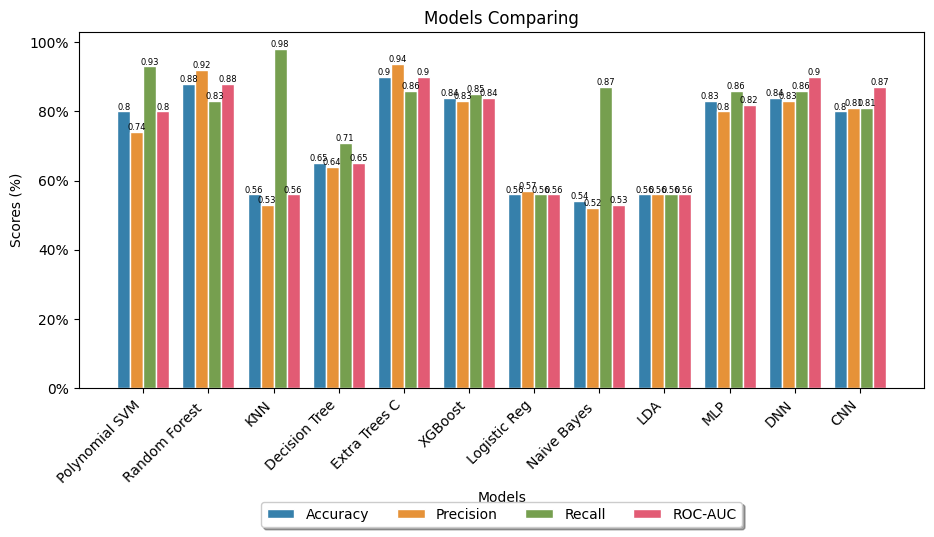

In [344]:
data = {
        'Polynomial SVM': {
        'validation accuracy': 0.80,
        'validation precision': 0.74,
        'validation recall': 0.93,
        'validation F1 score': 0.80
    },
    'Random Forest': {
        'validation accuracy': 0.88,
        'validation precision': 0.92,
        'validation recall': 0.83,
        'validation F1 score': 0.88
    },
    'KNN': {
        'validation accuracy': 0.56,
        'validation precision': 0.53,
        'validation recall': 0.98,
        'validation F1 score': 0.56
    },
    'Decision Tree': {
        'validation accuracy': 0.65,
        'validation precision': 0.64,
        'validation recall': 0.71,
        'validation F1 score': 0.65
    },
    'Extra Trees Classifier': {
        'validation accuracy': 0.9005,
        'validation precision': 0.9371,
        'validation recall': 0.8601,
        'validation F1 score': 0.9008
    },
    'XGBoost': {
        'validation accuracy': 0.84,
        'validation precision': 0.83,
        'validation recall': 0.85,
        'validation F1 score': 0.84
    },
    'Logistic Regression': {
        'validation accuracy': 0.56,
        'validation precision': 0.57,
        'validation recall': 0.56,
        'validation F1 score': 0.56
    },
    'Naive Bayes': {
        'validation accuracy': 0.54,
        'validation precision': 0.52,
        'validation recall': 0.87,
        'validation F1 score': 0.53
    },
    'Linear Discriminant Analysis': {
        'validation accuracy': 0.56,
        'validation precision': 0.56,
        'validation recall': 0.56,
        'validation F1 score': 0.56
    },
    'Multi-layer perceptron': {
        'validation accuracy': 0.83,
        'validation precision': 0.80,
        'validation recall': 0.86,
        'validation F1 score': 0.82
    },
    'DNN': {
        'validation accuracy': 0.84,
        'validation precision': 0.83,
        'validation recall': 0.86,
        'validation F1 score': 0.90
    },
    'CNN': {
        'validation accuracy': 0.80,
        'validation precision': 0.81,
        'validation recall': 0.81,
        'validation F1 score': 0.87
    }
}

display_grouped_bar_chart(data)


**By examining the performance metrics obtained from each model, we were able to chose the best model which is the Extra Trees Classifier**

# VII. Best Model Evaluation<a class="anchor" id="bme"></a>
**[Back to top](#toc)**

**We chose the Extra Trees Classifier Because it's the one that achieve the best result comparing to other models**

### Evaluate extra trees using cross validation

**We employed 5-fold cross-validation. This technique allowed us to evaluate the performance of the model across different subsets of the dataset. By dividing the data into five equally sized folds, we trained the model on four folds while validating its performance on the remaining fold. This process was repeated five times, with each fold serving as the validation set once.**

In [134]:
from sklearn.ensemble import ExtraTreesClassifier

# Create an Extra Trees Classifier model
ExtraTrees = ExtraTreesClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    bootstrap=False,
    random_state=60
)

# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
}

# Perform cross-validation with scoring metrics
cv_results = cross_validate(ExtraTrees, X_train, Y_train, cv=5, scoring=scoring, return_train_score=False)
specificity_cv = (2*cv_results['test_balanced_accuracy'])-cv_results['test_recall']
# Print the evaluation metrics from cross-validation
print("Cross-Validation Results:")
print("Accuracy:", cv_results['test_accuracy'])
print("Precision:", cv_results['test_precision'])
print("Recall:", cv_results['test_recall'])
print("F1-Score:", cv_results['test_f1_score'])
print("ROC-AUC Score:", cv_results['test_roc_auc'])
print("Specificity:", specificity_cv)
# Print the evaluation metrics with average and standard deviation
print("Avg+-Sd Results:")
print("Accuracy: {:.3f} +- {:.3f}".format(np.mean(cv_results['test_accuracy']), np.std(cv_results['test_accuracy'])))
print("Precision: {:.3f} +- {:.3f}".format(np.mean(cv_results['test_precision']), np.std(cv_results['test_precision'])))
print("Recall: {:.3f} +- {:.3f}".format(np.mean(cv_results['test_recall']), np.std(cv_results['test_recall'])))
print("F1-Score: {:.3f} +- {:.3f}".format(np.mean(cv_results['test_f1_score']), np.std(cv_results['test_f1_score'])))
print("ROC-AUC Score: {:.3f} +- {:.3f}".format(np.mean(cv_results['test_roc_auc']), np.std(cv_results['test_roc_auc'])))
print("Specificity: {:.3f} +- {:.3f}".format(np.mean(specificity_cv), np.std(specificity_cv)))


Cross-Validation Results:
Accuracy: [0.87280059 0.87793255 0.88123167 0.87756598 0.86950147]
Precision: [0.89180835 0.91727494 0.90801887 0.90345369 0.90630048]
Recall: [0.84790595 0.83039648 0.84801762 0.84508076 0.82378855]
F1-Score: [0.8693032  0.8716763  0.87699317 0.87329287 0.86307692]
ROC-AUC Score: [0.87274595 0.87786295 0.88118304 0.87751842 0.86943454]
Specificity: [0.89758595 0.92532943 0.91434846 0.90995608 0.91508053]
Avg+-Sd Results:
Accuracy: 0.876 +- 0.004
Precision: 0.905 +- 0.008
Recall: 0.839 +- 0.010
F1-Score: 0.871 +- 0.005
ROC-AUC Score: 0.876 +- 0.004
Specificity: 0.912 +- 0.009


### Area Under Curve (AUC)

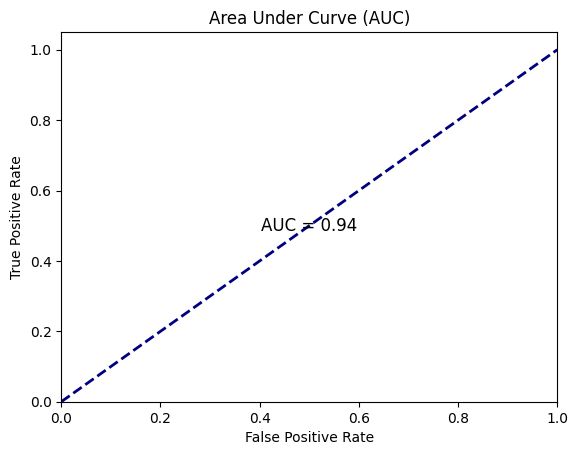

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Assuming you have the true labels Y_test and predicted probabilities Y_pred_proba
Y_pred_proba = ExtraTrees.predict_proba(X_test)

# The predicted probabilities for the positive class are typically in the second column
# Assuming you want the probabilities for the positive class (index 1)
Y_pred_proba_positive = Y_pred_proba[:, 1]
# Calculate the AUC
roc_auc = roc_auc_score(Y_test, Y_pred_proba_positive)

# Plot the AUC
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Curve (AUC)')
plt.text(0.5, 0.5, 'AUC = %0.2f' % roc_auc, ha='center', va='center', fontsize=12)
plt.show()


### Receiver Operating Characteristic

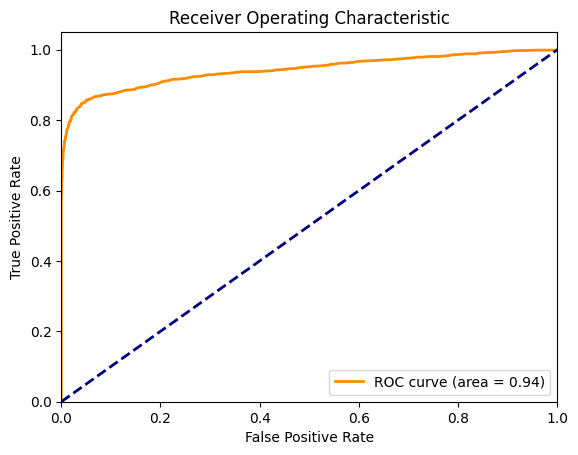

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have the true labels Y_test and predicted probabilities Y_pred_proba

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba_positive)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0s])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Learning Curve

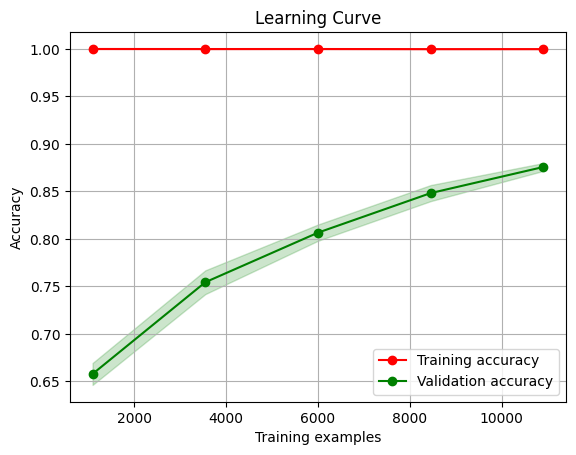

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training accuracy')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation accuracy')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='r')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2, color='g')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Assuming you have your model, training data X_train, and corresponding labels y_train

# Call the function to plot the learning curve
plot_learning_curve(ExtraTrees, X_train, Y_train, cv=5)


### confusion matrix

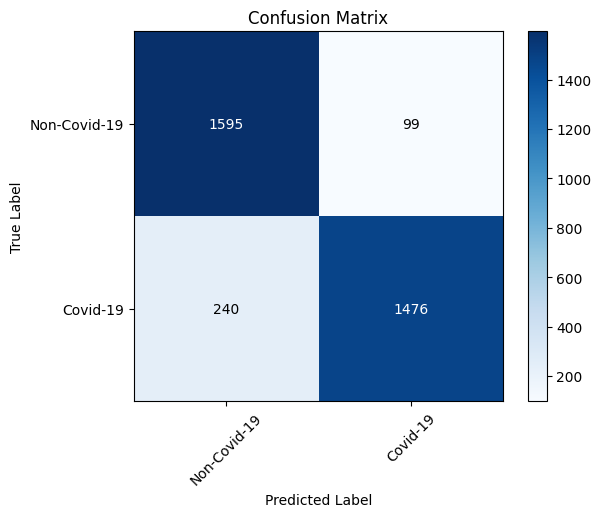

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels Y_test and predicted labels Y_pred

# Calculate the confusion matrix
cm = confusion_matrix(Y_test, Y_pred_ExtraTrees)

# Create a function to plot the confusion matrix with details
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add numerical values to the confusion matrix cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define the class labels
class_labels = ['Non-Covid-19', 'Covid-19']

# Plot the confusion matrix with details
plot_confusion_matrix(cm, class_labels)


### Precision-Recall Curve

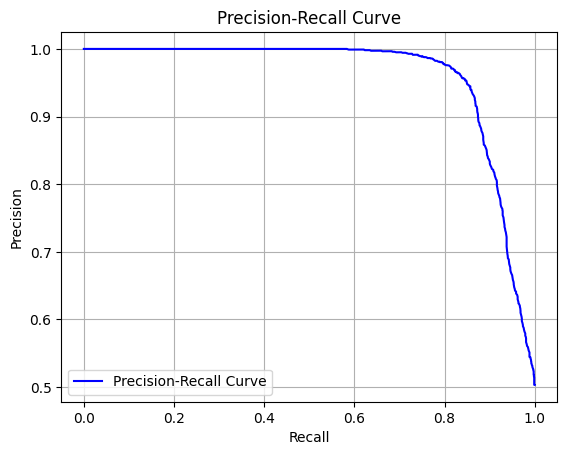

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Assuming you have the true labels Y_test and predicted probabilities Y_pred_proba_positive

# Calculate precision and recall values at different thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred_proba_positive)

# Plot the precision-recall curve
plt.plot(recall, precision, color='b', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Exporting our best model

In [135]:
import pickle
path = "/Users/iyadchehili/Desktop/exported_model/ExtraTrees.sav"
pickle.dump(ExtraTrees,open(path,'wb'))

In [99]:
import pickle
path = "/Users/iyadchehili/Desktop/exported_model/ExtraTrees.sav"
model1 = pickle.load(open(path, 'rb'))